# 步骤
1.使用prophet和arima模型训练数据，根据结果判断模型好坏
2.通过对一周中每天的影响因子以及去掉影响因子后每月的pure_base来计算9月中每天的额度

In [2]:
import pandas as pd
data=pd.read_csv('./user_balance_table.csv',parse_dates=['report_date'])
data

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,2014-08-05,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,2014-08-08,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,2014-08-11,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,2014-08-14,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,2014-08-17,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840416,28033,2014-08-25,550646,550585,61,0,0,0,0,0,0,0,0,61,NaN,NaN,NaN,NaN
2840417,28033,2014-08-31,525707,538147,60,0,0,0,12500,12500,0,0,0,60,0.0,0.0,0.0,12500.0
2840418,28033,2014-07-24,20487121,20484824,2297,0,0,0,0,0,0,0,0,2297,NaN,NaN,NaN,NaN
2840419,28033,2014-07-27,20462288,20491722,2298,0,0,0,31732,0,31732,0,31732,2298,NaN,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2840421 entries, 0 to 2840420
Data columns (total 18 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_id              int64         
 1   report_date          datetime64[ns]
 2   tBalance             int64         
 3   yBalance             int64         
 4   total_purchase_amt   int64         
 5   direct_purchase_amt  int64         
 6   purchase_bal_amt     int64         
 7   purchase_bank_amt    int64         
 8   total_redeem_amt     int64         
 9   consume_amt          int64         
 10  transfer_amt         int64         
 11  tftobal_amt          int64         
 12  tftocard_amt         int64         
 13  share_amt            int64         
 14  category1            float64       
 15  category2            float64       
 16  category3            float64       
 17  category4            float64       
dtypes: datetime64[ns](1), float64(4), int64(13)
memory usage: 390.

In [4]:
total_balance=data.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()
total_balance

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,total_purchase_amt,total_redeem_amt
report_date,,
2013-07-01,32488348,5525022
2013-07-02,29037390,2554548
2013-07-03,27270770,5953867
2013-07-04,18321185,6410729
2013-07-05,11648749,2763587
...,...,...
2014-08-27,302194801,468164147
2014-08-28,245082751,297893861
2014-08-29,267554713,273756380


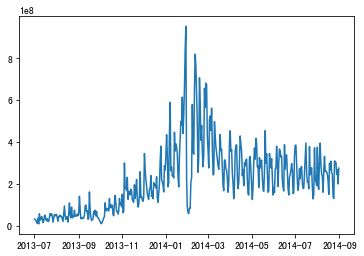

In [5]:
import matplotlib.pyplot as plt
plt.plot(total_balance['total_purchase_amt'])
plt.show()

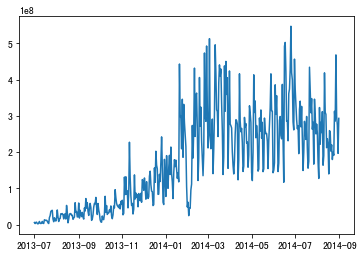

In [6]:
plt.plot(total_balance['total_redeem_amt'])
plt.show()

In [7]:
purchase=total_balance[['total_purchase_amt']]
redeem=total_balance[['total_redeem_amt']]
purchase

,total_purchase_amt
report_date,
2013-07-01,32488348
2013-07-02,29037390
2013-07-03,27270770
2013-07-04,18321185
2013-07-05,11648749
...,...
2014-08-27,302194801
2014-08-28,245082751
2014-08-29,267554713


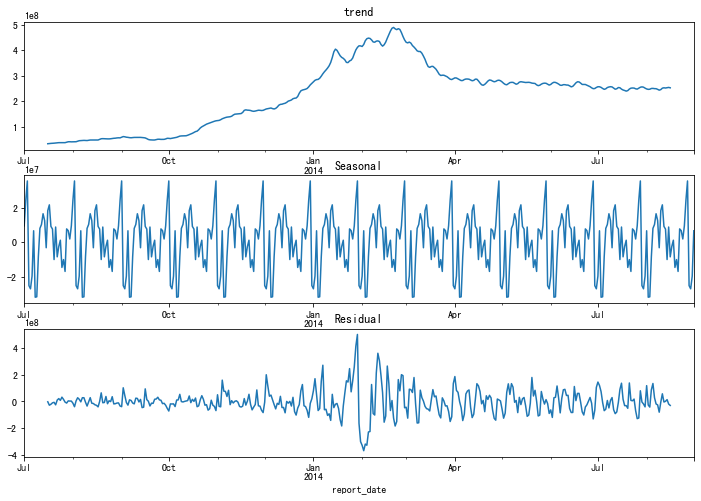

In [8]:
import statsmodels.api as sm
#对指定时间内的数据进行可视化
def plot_stl(data):
    result=sm.tsa.seasonal_decompose(data,period=30)
    fig=plt.figure(figsize=(12,8))
    ax1=fig.add_subplot(311)
    ax2=fig.add_subplot(312)
    ax3=fig.add_subplot(313)
    result.trend.plot(ax=ax1,title='trend')
    result.seasonal.plot(ax=ax2,title='Seasonal')
    result.resid.plot(ax=ax3,title='Residual')
plot_stl(purchase.total_purchase_amt)

# 1.Prophet模型

In [9]:
purchase['ds']=purchase.index
purchase.rename(columns={'total_purchase_amt':'y'},inplace=True)
purchase

,y,ds
report_date,,
2013-07-01,32488348,2013-07-01
2013-07-02,29037390,2013-07-02
2013-07-03,27270770,2013-07-03
2013-07-04,18321185,2013-07-04
2013-07-05,11648749,2013-07-05
...,...,...
2014-08-27,302194801,2014-08-27
2014-08-28,245082751,2014-08-28
2014-08-29,267554713,2014-08-29


In [10]:
redeem['ds']=redeem.index
redeem.rename(columns={'total_redeem_amt':'y'},inplace=True)
redeem

,y,ds
report_date,,
2013-07-01,5525022,2013-07-01
2013-07-02,2554548,2013-07-02
2013-07-03,5953867,2013-07-03
2013-07-04,6410729,2013-07-04
2013-07-05,2763587,2013-07-05
...,...,...
2014-08-27,468164147,2014-08-27
2014-08-28,297893861,2014-08-28
2014-08-29,273756380,2014-08-29


In [11]:
purchase=purchase.reset_index(drop=True)
redeem=redeem.reset_index(drop=True)

In [12]:
from fbprophet import Prophet
#seasonality_prior_scale改变季节性模型的强度，默认为10
model=Prophet(weekly_seasonality=True,n_changepoints=300,seasonality_prior_scale=0.1)
model.fit(purchase)
future=model.make_future_dataframe(periods=30)
purchase_pred=model.predict(future)
purchase_pred

Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-07-01,6.659731e+06,-6.300814e+07,1.594647e+08,6.659731e+06,6.659731e+06,4.477745e+07,4.477745e+07,4.477745e+07,4.477745e+07,4.477745e+07,4.477745e+07,0.0,0.0,0.0,5.143718e+07
1,2013-07-02,7.449143e+06,-5.824847e+07,1.702597e+08,7.449143e+06,7.449143e+06,4.753561e+07,4.753561e+07,4.753561e+07,4.753561e+07,4.753561e+07,4.753561e+07,0.0,0.0,0.0,5.498475e+07
2,2013-07-03,8.238556e+06,-6.767418e+07,1.650308e+08,8.238556e+06,8.238556e+06,3.765459e+07,3.765459e+07,3.765459e+07,3.765459e+07,3.765459e+07,3.765459e+07,0.0,0.0,0.0,4.589314e+07
3,2013-07-04,9.027968e+06,-8.937496e+07,1.442311e+08,9.027968e+06,9.027968e+06,1.949534e+07,1.949534e+07,1.949534e+07,1.949534e+07,1.949534e+07,1.949534e+07,0.0,0.0,0.0,2.852330e+07
4,2013-07-05,9.817381e+06,-1.266609e+08,1.014022e+08,9.817381e+06,9.817381e+06,-1.786047e+07,-1.786047e+07,-1.786047e+07,-1.786047e+07,-1.786047e+07,-1.786047e+07,0.0,0.0,0.0,-8.043092e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,2014-09-26,1.996987e+08,6.982132e+07,2.970404e+08,1.979064e+08,2.012450e+08,-1.786047e+07,-1.786047e+07,-1.786047e+07,-1.786047e+07,-1.786047e+07,-1.786047e+07,0.0,0.0,0.0,1.818382e+08
453,2014-09-27,1.989459e+08,1.213563e+07,2.415752e+08,1.970280e+08,2.005749e+08,-6.945456e+07,-6.945456e+07,-6.945456e+07,-6.945456e+07,-6.945456e+07,-6.945456e+07,0.0,0.0,0.0,1.294913e+08
454,2014-09-28,1.981931e+08,2.062113e+07,2.517489e+08,1.961567e+08,1.999090e+08,-6.214795e+07,-6.214795e+07,-6.214795e+07,-6.214795e+07,-6.214795e+07,-6.214795e+07,0.0,0.0,0.0,1.360452e+08
455,2014-09-29,1.974403e+08,1.258048e+08,3.583305e+08,1.953037e+08,1.992412e+08,4.477745e+07,4.477745e+07,4.477745e+07,4.477745e+07,4.477745e+07,4.477745e+07,0.0,0.0,0.0,2.422178e+08


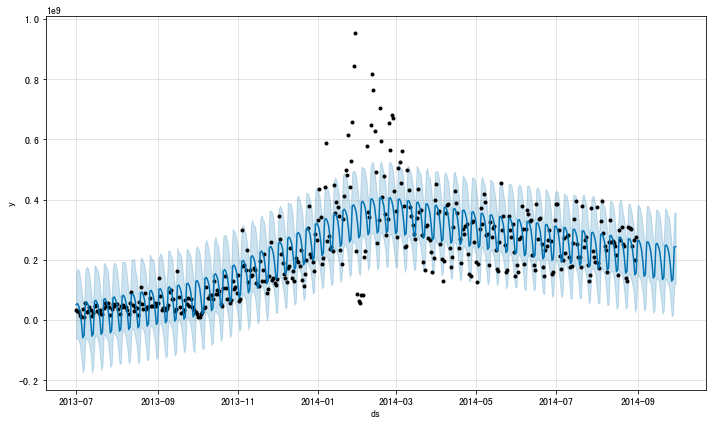

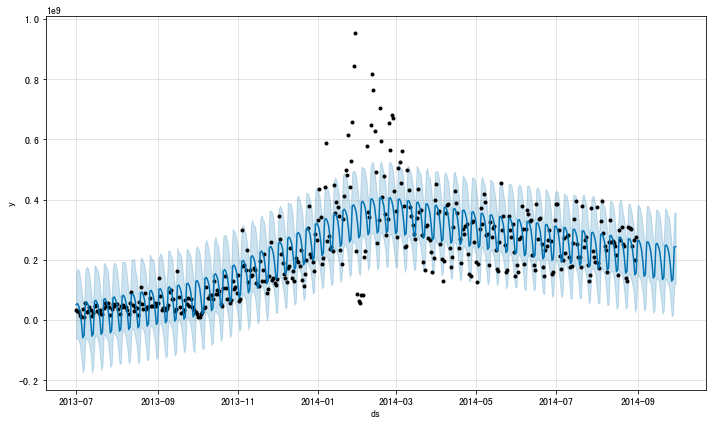

In [13]:
model.plot(purchase_pred)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


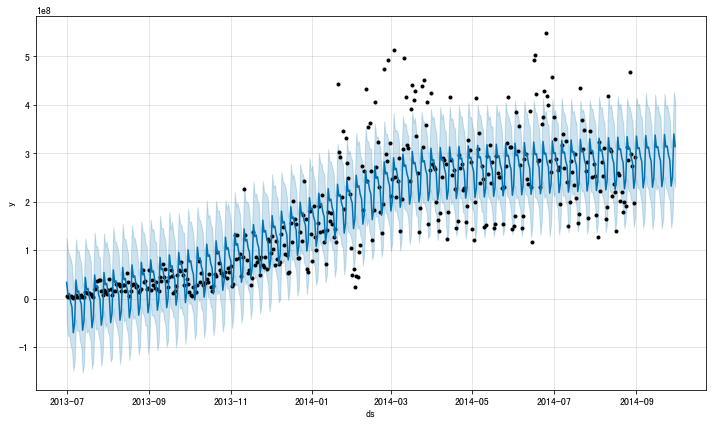

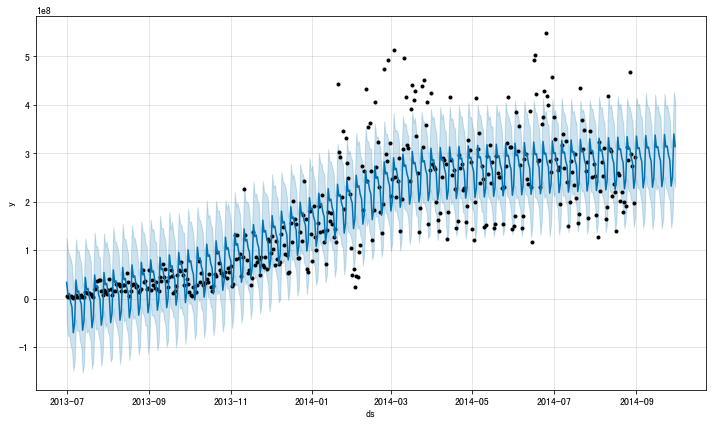

In [14]:
model2=Prophet(weekly_seasonality=True,n_changepoints=300,seasonality_prior_scale=0.1)
model2.fit(redeem)
future=model2.make_future_dataframe(periods=30)
redeem_pred=model2.predict(future)
redeem_pred
model2.plot(redeem_pred)

In [15]:
purchase2=purchase_pred[(purchase_pred['ds']>='2014-09-01')&(purchase_pred['ds']<='2014-09-30')]
redeem2=redeem_pred[(redeem_pred['ds']>='2014-09-01')&(redeem_pred['ds']<='2014-09-30')]

In [16]:
#合并提交结果
result=pd.DataFrame()
result['ds']=purchase2.ds
result['purchase_amt']=purchase2.yhat
result['redeem_amt']=redeem2.yhat
result

,ds,purchase_amt,redeem_amt
427,2014-09-01,2.632957e+08,3.353353e+08
428,2014-09-02,2.653011e+08,3.092673e+08
429,2014-09-03,2.546673e+08,3.115720e+08
430,2014-09-04,2.357553e+08,2.929777e+08
431,2014-09-05,1.976467e+08,2.825034e+08
432,2014-09-06,1.452998e+08,2.287263e+08
433,2014-09-07,1.518536e+08,2.476110e+08
434,2014-09-08,2.580262e+08,3.364518e+08
435,2014-09-09,2.600316e+08,3.103838e+08
436,2014-09-10,2.493978e+08,3.126885e+08


In [17]:
result['ds']=result['ds'].apply(lambda x:str(x).replace('-','')[0:8])
result

,ds,purchase_amt,redeem_amt
427,20140901,2.632957e+08,3.353353e+08
428,20140902,2.653011e+08,3.092673e+08
429,20140903,2.546673e+08,3.115720e+08
430,20140904,2.357553e+08,2.929777e+08
431,20140905,1.976467e+08,2.825034e+08
432,20140906,1.452998e+08,2.287263e+08
433,20140907,1.518536e+08,2.476110e+08
434,20140908,2.580262e+08,3.364518e+08
435,20140909,2.600316e+08,3.103838e+08
436,20140910,2.493978e+08,3.126885e+08


In [18]:
result.to_csv('prophet_purchase_redeem.csv',header=None,index=False)
day_pred1=result

# 2.ARIMA模型

([<matplotlib.axis.XTick at 0x7ff0f1015250>,
 <a list of 153 Text xticklabel objects>)

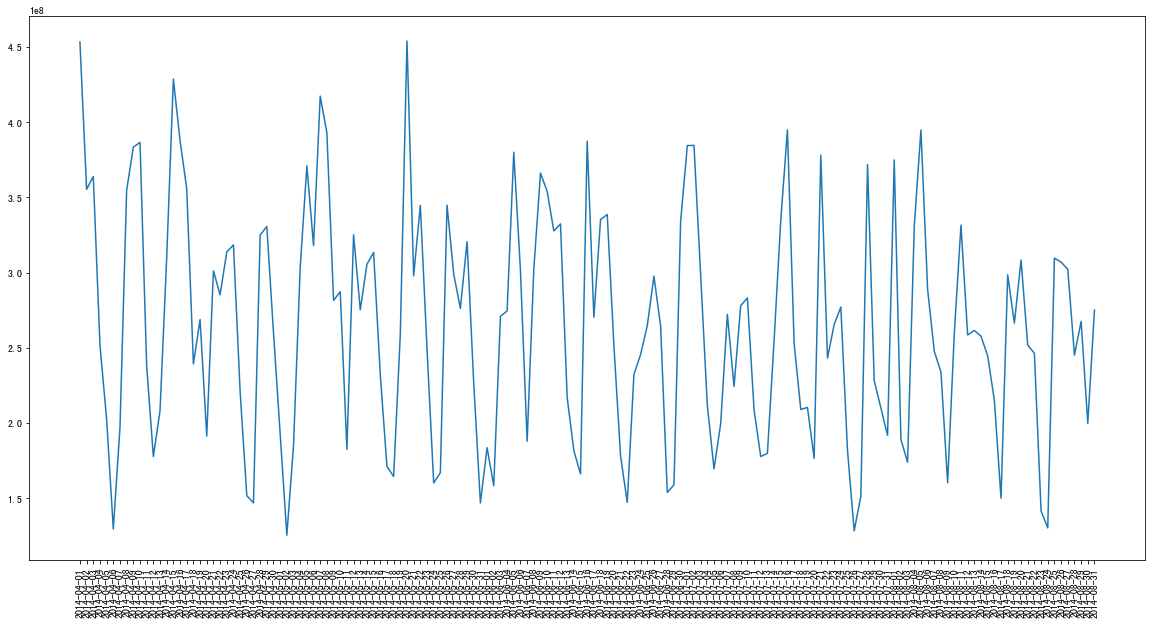

In [19]:
#获取4月1号以后的数据，因为这部分数据相对稳定
purchase=total_balance[['total_purchase_amt']]
redeem=total_balance[['total_redeem_amt']]
purchase2=purchase[(purchase.index>='2014-04-01')]
#redeem=redeem[(redeem.index>='2014-04-01')]

plt.figure(figsize=(20,10))
plt.plot(purchase2.total_purchase_amt)
data_range=pd.date_range('2014-04-01','2014-08-31')
plt.xticks(data_range,rotation=90)


In [20]:
from statsmodels.tsa.stattools import adfuller
t=adfuller(purchase['total_purchase_amt'])
t
#purchase原数据不平稳，做差分,1阶差分之后平稳
diff1=purchase.diff(1)
t2=adfuller(diff1[1:])
t2

(-7.947102224652343,
 3.198186862488185e-12,
 18,
 407,
 {'1%': -3.4465195891135845,
  '5%': -2.8686676281678634,
  '10%': -2.5705668101226085},
 15918.844657651942)

In [21]:
from statsmodels.tsa.stattools import adfuller
t3=adfuller(redeem['total_redeem_amt'])
print(t3)
#redeem原数据不平稳，做差分,1阶差分之后平稳
diff2=redeem.diff(1)
t4=adfuller(diff2[1:])
print(t4)

(-1.372413679828339, 0.5954275877949474, 13, 413, {'1%': -3.4462831955497135, '5%': -2.8685636962704395, '10%': -2.5705114078759914}, 15816.780952766481)
(-11.69198690696884, 1.6443717458497645e-21, 12, 413, {'1%': -3.4462831955497135, '5%': -2.8685636962704395, '10%': -2.5705114078759914}, 15779.04993673871)


In [22]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(purchase,order=(7,1,5)).fit()
purchase_pred=model.predict('2014-09-01','2014-09-30',typ='levels')
purchase_pred

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2014-09-01    3.310539e+08
2014-09-02    3.318762e+08
2014-09-03    3.338910e+08
2014-09-04    2.983191e+08
2014-09-05    2.407509e+08
2014-09-06    2.266140e+08
2014-09-07    2.435554e+08
2014-09-08    2.970865e+08
2014-09-09    3.321274e+08
2014-09-10    3.265197e+08
2014-09-11    2.916841e+08
2014-09-12    2.392702e+08
2014-09-13    2.253550e+08
2014-09-14    2.475289e+08
2014-09-15    2.950936e+08
2014-09-16    3.345010e+08
2014-09-17    3.280818e+08
2014-09-18    2.927099e+08
2014-09-19    2.448967e+08
2014-09-20    2.275711e+08
2014-09-21    2.530230e+08
2014-09-22    2.980719e+08
2014-09-23    3.366748e+08
2014-09-24    3.321948e+08
2014-09-25    2.947106e+08
2014-09-26    2.505384e+08
2014-09-27    2.318269e+08
2014-09-28    2.574471e+08
2014-09-29    3.025702e+08
2014-09-30    3.387019e+08
Freq: D, dtype: float64

In [23]:
model2=ARIMA(redeem,order=(7,1,5)).fit()
redeem_pred=model2.predict('2014-09-01','2014-09-30',typ='levels')
redeem_pred

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2014-09-01    3.169090e+08
2014-09-02    3.372455e+08
2014-09-03    3.632442e+08
2014-09-04    3.074694e+08
2014-09-05    2.628057e+08
2014-09-06    2.258706e+08
2014-09-07    2.592158e+08
2014-09-08    3.115468e+08
2014-09-09    3.477437e+08
2014-09-10    3.562431e+08
2014-09-11    3.092719e+08
2014-09-12    2.598512e+08
2014-09-13    2.339112e+08
2014-09-14    2.578186e+08
2014-09-15    3.125493e+08
2014-09-16    3.537239e+08
2014-09-17    3.573622e+08
2014-09-18    3.146179e+08
2014-09-19    2.626592e+08
2014-09-20    2.387440e+08
2014-09-21    2.616172e+08
2014-09-22    3.157165e+08
2014-09-23    3.588117e+08
2014-09-24    3.611535e+08
2014-09-25    3.197931e+08
2014-09-26    2.672031e+08
2014-09-27    2.432839e+08
2014-09-28    2.661170e+08
2014-09-29    3.197114e+08
2014-09-30    3.635485e+08
Freq: D, dtype: float64

In [24]:
print(model.aic)
print(model2.aic)

16669.646033929606
16519.896275849063


In [25]:
#合并提交结果
result=pd.DataFrame()
result['date']=purchase_pred.index
result['purchase_amt']=purchase_pred.values
result['redeem_amt']=redeem_pred.values
result

,date,purchase_amt,redeem_amt
0,2014-09-01,3.310539e+08,3.169090e+08
1,2014-09-02,3.318762e+08,3.372455e+08
2,2014-09-03,3.338910e+08,3.632442e+08
3,2014-09-04,2.983191e+08,3.074694e+08
4,2014-09-05,2.407509e+08,2.628057e+08
5,2014-09-06,2.266140e+08,2.258706e+08
6,2014-09-07,2.435554e+08,2.592158e+08
7,2014-09-08,2.970865e+08,3.115468e+08
8,2014-09-09,3.321274e+08,3.477437e+08
9,2014-09-10,3.265197e+08,3.562431e+08


In [26]:
result['date']=result['date'].apply(lambda x:str(x).replace('-','')[0:8])
result

,date,purchase_amt,redeem_amt
0,20140901,3.310539e+08,3.169090e+08
1,20140902,3.318762e+08,3.372455e+08
2,20140903,3.338910e+08,3.632442e+08
3,20140904,2.983191e+08,3.074694e+08
4,20140905,2.407509e+08,2.628057e+08
5,20140906,2.266140e+08,2.258706e+08
6,20140907,2.435554e+08,2.592158e+08
7,20140908,2.970865e+08,3.115468e+08
8,20140909,3.321274e+08,3.477437e+08
9,20140910,3.265197e+08,3.562431e+08


In [27]:
result.to_csv('arima_purchase_redeem.csv',header=None,index=False)
day_pred2=result

# 方案3

In [28]:
import datetime
import numpy as np
import pandas as pd
data=pd.read_csv('./user_balance_table.csv')
data

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,20140805,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,20140808,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,20140811,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,20140814,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,20140817,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840416,28033,20140825,550646,550585,61,0,0,0,0,0,0,0,0,61,NaN,NaN,NaN,NaN
2840417,28033,20140831,525707,538147,60,0,0,0,12500,12500,0,0,0,60,0.0,0.0,0.0,12500.0
2840418,28033,20140724,20487121,20484824,2297,0,0,0,0,0,0,0,0,2297,NaN,NaN,NaN,NaN
2840419,28033,20140727,20462288,20491722,2298,0,0,0,31732,0,31732,0,31732,2298,NaN,NaN,NaN,NaN


In [29]:
def add_timestamp(data):
    #print(data['report_date'])
    data['report_date']=pd.to_datetime(data['report_date'],format='%Y%m%d')
    data['day']=data['report_date'].dt.day
    data['month']=data['report_date'].dt.month
    data['year']=data['report_date'].dt.year
    data['week']=data['report_date'].dt.week
    data['weekday']=data['report_date'].dt.weekday#星期几,0是星期一
    #print(data['report_date'])
    return data
#print(data['report_date'])
data=add_timestamp(data)
data

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,...,share_amt,category1,category2,category3,category4,day,month,year,week,weekday
0,1,2014-08-05,20385,20383,2,0,0,0,0,0,...,2,NaN,NaN,NaN,NaN,5,8,2014,32,1
1,1,2014-08-08,20391,20389,2,0,0,0,0,0,...,2,NaN,NaN,NaN,NaN,8,8,2014,32,4
2,1,2014-08-11,20397,20395,2,0,0,0,0,0,...,2,NaN,NaN,NaN,NaN,11,8,2014,33,0
3,1,2014-08-14,20403,20401,2,0,0,0,0,0,...,2,NaN,NaN,NaN,NaN,14,8,2014,33,3
4,1,2014-08-17,20409,20407,2,0,0,0,0,0,...,2,NaN,NaN,NaN,NaN,17,8,2014,33,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840416,28033,2014-08-25,550646,550585,61,0,0,0,0,0,...,61,NaN,NaN,NaN,NaN,25,8,2014,35,0
2840417,28033,2014-08-31,525707,538147,60,0,0,0,12500,12500,...,60,0.0,0.0,0.0,12500.0,31,8,2014,35,6
2840418,28033,2014-07-24,20487121,20484824,2297,0,0,0,0,0,...,2297,NaN,NaN,NaN,NaN,24,7,2014,30,3
2840419,28033,2014-07-27,20462288,20491722,2298,0,0,0,31732,0,...,2298,NaN,NaN,NaN,NaN,27,7,2014,30,6


In [30]:
data['report_date'].min()

Timestamp('2013-07-01 00:00:00')

In [31]:
def get_total_balance(data,begin):
    df_temp=data.copy()
    df_temp=df_temp.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()
    #print(df_temp)
    df_temp.reset_index(inplace=True)
    df_temp=df_temp[df_temp['report_date']>=begin]
    print(df_temp)
    return df_temp
total_balance=get_total_balance(data,'2014-02-01')

    report_date  total_purchase_amt  total_redeem_amt
215  2014-02-01            64287172          61527060
216  2014-02-02            57912761          24395720
217  2014-02-03            84329848          46109194
218  2014-02-04            83653646          44927333
219  2014-02-05           209043990          95407704
..          ...                 ...               ...
422  2014-08-27           302194801         468164147
423  2014-08-28           245082751         297893861
424  2014-08-29           267554713         273756380
425  2014-08-30           199708772         196374134
426  2014-08-31           275090213         292943033

[212 rows x 3 columns]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:

#拼接测试数据和之前的数据
def generate_test_data(data):
    total_balance=data.copy()
    start=datetime.datetime(2014,9,1)
    end=datetime.datetime(2014,10,1)
    testdata=[]
    while start != end:
        temp=[start,np.nan,np.nan]
        testdata.append(temp)
        start+=datetime.timedelta(days=1)
    testdata=pd.DataFrame(testdata)
    testdata.columns=total_balance.columns
    total_balance=pd.concat([total_balance,testdata],axis=0) 
    return total_balance
    
total_balance=generate_test_data(total_balance)

In [33]:
total_balance=add_timestamp(total_balance)
total_balance

,report_date,total_purchase_amt,total_redeem_amt,day,month,year,week,weekday
215,2014-02-01,64287172.0,61527060.0,1,2,2014,5,5
216,2014-02-02,57912761.0,24395720.0,2,2,2014,5,6
217,2014-02-03,84329848.0,46109194.0,3,2,2014,6,0
218,2014-02-04,83653646.0,44927333.0,4,2,2014,6,1
219,2014-02-05,209043990.0,95407704.0,5,2,2014,6,2
...,...,...,...,...,...,...,...,...
25,2014-09-26,NaN,NaN,26,9,2014,39,4
26,2014-09-27,NaN,NaN,27,9,2014,39,5
27,2014-09-28,NaN,NaN,28,9,2014,39,6
28,2014-09-29,NaN,NaN,29,9,2014,40,0


In [34]:
#数据备份
temp=total_balance.copy()


In [35]:
total_balance=temp.copy()

weekday_weight=total_balance[['weekday','total_purchase_amt','total_redeem_amt']].groupby('weekday',as_index=False).mean()
weekday_weight=weekday_weight.rename(columns={'total_purchase_amt':'purchase_weekday','total_redeem_amt':'redeem_weekday'})
weekday_weight

,weekday,purchase_weekday,redeem_weekday
0,0,3.535277e+08,3.448281e+08
1,1,3.581624e+08,3.077852e+08
2,2,3.472435e+08,3.110634e+08
3,3,3.396120e+08,2.844627e+08
4,4,2.777918e+08,2.668964e+08
5,5,2.015599e+08,1.764718e+08
6,6,2.057319e+08,2.037772e+08


In [36]:
weekday_weight['purchase_weekday']/=np.mean(total_balance['total_purchase_amt'])
weekday_weight['redeem_weekday']/=np.mean(total_balance['total_redeem_amt'])
weekday_weight

,weekday,purchase_weekday,redeem_weekday
0,0,1.191234,1.277168
1,1,1.206851,1.139969
2,2,1.170059,1.152111
3,3,1.144344,1.053588
4,4,0.936037,0.988526
5,5,0.679169,0.653613
6,6,0.693227,0.754746


In [37]:
total_balance=pd.merge(total_balance,weekday_weight,on='weekday',how='left')
total_balance

,report_date,total_purchase_amt,total_redeem_amt,day,month,year,week,weekday,purchase_weekday,redeem_weekday
0,2014-02-01,64287172.0,61527060.0,1,2,2014,5,5,0.679169,0.653613
1,2014-02-02,57912761.0,24395720.0,2,2,2014,5,6,0.693227,0.754746
2,2014-02-03,84329848.0,46109194.0,3,2,2014,6,0,1.191234,1.277168
3,2014-02-04,83653646.0,44927333.0,4,2,2014,6,1,1.206851,1.139969
4,2014-02-05,209043990.0,95407704.0,5,2,2014,6,2,1.170059,1.152111
...,...,...,...,...,...,...,...,...,...,...
237,2014-09-26,NaN,NaN,26,9,2014,39,4,0.936037,0.988526
238,2014-09-27,NaN,NaN,27,9,2014,39,5,0.679169,0.653613
239,2014-09-28,NaN,NaN,28,9,2014,39,6,0.693227,0.754746
240,2014-09-29,NaN,NaN,29,9,2014,40,0,1.191234,1.277168


In [38]:
#计算日期因子
weekday_count=total_balance[['report_date','weekday','day']].groupby(['weekday','day'],as_index=False).count()
weekday_count=pd.merge(weekday_count,weekday_weight,on='weekday')
weekday_count

,weekday,day,report_date,purchase_weekday,redeem_weekday
0,0,1,1,1.191234,1.277168
1,0,2,1,1.191234,1.277168
2,0,3,2,1.191234,1.277168
3,0,4,1,1.191234,1.277168
4,0,5,1,1.191234,1.277168
...,...,...,...,...,...
179,6,27,2,0.693227,0.754746
180,6,28,1,0.693227,0.754746
181,6,29,1,0.693227,0.754746
182,6,30,1,0.693227,0.754746


In [39]:
len(np.unique(total_balance['month']))

8

In [40]:
weekday_count['purchase_weekday']=weekday_count['purchase_weekday']*weekday_count['report_date']/len(np.unique(total_balance['month']))


In [41]:
weekday_count['redeem_weekday']=weekday_count['redeem_weekday']*weekday_count['report_date']/len(np.unique(total_balance['month']))

In [42]:
day_rate=weekday_count.drop(['weekday','report_date'],axis=1).groupby('day',as_index=False).sum()
day_rate

,day,purchase_weekday,redeem_weekday
0,1,0.967110,0.957649
1,2,0.967483,0.984124
2,3,1.052558,1.045244
3,4,1.060580,1.061825
4,5,1.022115,1.008837
5,6,0.958407,0.943861
6,7,0.992668,1.018181
7,8,0.967110,0.957649
8,9,0.967483,0.984124
9,10,1.052558,1.045244


In [43]:
day_mean=total_balance[['day','total_purchase_amt','total_redeem_amt']].groupby('day',as_index=False).mean()
day_mean

,day,total_purchase_amt,total_redeem_amt
0,1,2.880460e+08,2.100190e+08
1,2,2.209522e+08,1.908628e+08
2,3,2.687450e+08,2.610082e+08
3,4,2.827907e+08,2.571837e+08
4,5,3.115439e+08,2.324140e+08
5,6,2.895617e+08,2.268871e+08
6,7,3.258362e+08,2.426264e+08
7,8,3.013505e+08,2.383693e+08
8,9,2.936961e+08,2.467308e+08
9,10,3.878962e+08,2.840094e+08


In [44]:
day_pred=pd.merge(day_mean,day_rate,on='day',how='left')
day_pred['total_purchase_amt']/=day_pred['purchase_weekday']
day_pred['total_redeem_amt']/=day_pred['redeem_weekday']
day_pred

,day,total_purchase_amt,total_redeem_amt,purchase_weekday,redeem_weekday
0,1,2.978419e+08,2.193068e+08,0.967110,0.957649
1,2,2.283785e+08,1.939419e+08,0.967483,0.984124
2,3,2.553257e+08,2.497104e+08,1.052558,1.045244
3,4,2.666378e+08,2.422090e+08,1.060580,1.061825
4,5,3.048032e+08,2.303781e+08,1.022115,1.008837
5,6,3.021281e+08,2.403820e+08,0.958407,0.943861
6,7,3.282430e+08,2.382940e+08,0.992668,1.018181
7,8,3.115990e+08,2.489109e+08,0.967110,0.957649
8,9,3.035673e+08,2.507111e+08,0.967483,0.984124
9,10,3.685272e+08,2.717159e+08,1.052558,1.045244


In [45]:
for index,row in day_pred.iterrows():
    if row['day']==31:
        break
    day_pred.loc[index,'report_date']=pd.to_datetime('2014/09/'+str(int(row['day'])))
day_pred

,day,total_purchase_amt,total_redeem_amt,purchase_weekday,redeem_weekday,report_date
0,1,2.978419e+08,2.193068e+08,0.967110,0.957649,2014-09-01
1,2,2.283785e+08,1.939419e+08,0.967483,0.984124,2014-09-02
2,3,2.553257e+08,2.497104e+08,1.052558,1.045244,2014-09-03
3,4,2.666378e+08,2.422090e+08,1.060580,1.061825,2014-09-04
4,5,3.048032e+08,2.303781e+08,1.022115,1.008837,2014-09-05
5,6,3.021281e+08,2.403820e+08,0.958407,0.943861,2014-09-06
6,7,3.282430e+08,2.382940e+08,0.992668,1.018181,2014-09-07
7,8,3.115990e+08,2.489109e+08,0.967110,0.957649,2014-09-08
8,9,3.035673e+08,2.507111e+08,0.967483,0.984124,2014-09-09
9,10,3.685272e+08,2.717159e+08,1.052558,1.045244,2014-09-10


In [46]:
#base*周期因子
day_pred['weekday']=day_pred['report_date'].dt.weekday
day_pred

,day,total_purchase_amt,total_redeem_amt,purchase_weekday,redeem_weekday,report_date,weekday
0,1,2.978419e+08,2.193068e+08,0.967110,0.957649,2014-09-01,0.0
1,2,2.283785e+08,1.939419e+08,0.967483,0.984124,2014-09-02,1.0
2,3,2.553257e+08,2.497104e+08,1.052558,1.045244,2014-09-03,2.0
3,4,2.666378e+08,2.422090e+08,1.060580,1.061825,2014-09-04,3.0
4,5,3.048032e+08,2.303781e+08,1.022115,1.008837,2014-09-05,4.0
5,6,3.021281e+08,2.403820e+08,0.958407,0.943861,2014-09-06,5.0
6,7,3.282430e+08,2.382940e+08,0.992668,1.018181,2014-09-07,6.0
7,8,3.115990e+08,2.489109e+08,0.967110,0.957649,2014-09-08,0.0
8,9,3.035673e+08,2.507111e+08,0.967483,0.984124,2014-09-09,1.0
9,10,3.685272e+08,2.717159e+08,1.052558,1.045244,2014-09-10,2.0


In [47]:
day_pred=day_pred[['day','total_purchase_amt','total_redeem_amt','report_date','weekday']]

In [48]:
day_pred=pd.merge(day_pred,weekday_weight,on='weekday')
day_pred

,day,total_purchase_amt,total_redeem_amt,report_date,weekday,purchase_weekday,redeem_weekday
0,1,2.978419e+08,2.193068e+08,2014-09-01,0.0,1.191234,1.277168
1,8,3.115990e+08,2.489109e+08,2014-09-08,0.0,1.191234,1.277168
2,15,2.999053e+08,2.241688e+08,2014-09-15,0.0,1.191234,1.277168
3,22,2.570529e+08,2.539510e+08,2014-09-22,0.0,1.191234,1.277168
4,29,2.769277e+08,3.072520e+08,2014-09-29,0.0,1.191234,1.277168
5,2,2.283785e+08,1.939419e+08,2014-09-02,1.0,1.206851,1.139969
6,9,3.035673e+08,2.507111e+08,2014-09-09,1.0,1.206851,1.139969
7,16,3.274751e+08,2.987416e+08,2014-09-16,1.0,1.206851,1.139969
8,23,2.520289e+08,2.570291e+08,2014-09-23,1.0,1.206851,1.139969
9,30,2.716858e+08,3.301175e+08,2014-09-30,1.0,1.206851,1.139969


In [49]:
day_pred['total_purchase_amt']*=day_pred['purchase_weekday']
day_pred['total_redeem_amt']*=day_pred['redeem_weekday']
day_pred=day_pred.sort_values('report_date')[['report_date','total_purchase_amt','total_redeem_amt']]

In [50]:
day_pred

,report_date,total_purchase_amt,total_redeem_amt
0,2014-09-01,3.547994e+08,2.800916e+08
5,2014-09-02,2.756188e+08,2.210878e+08
10,2014-09-03,2.987460e+08,2.876940e+08
14,2014-09-04,3.051254e+08,2.551885e+08
18,2014-09-05,2.853070e+08,2.277347e+08
22,2014-09-06,2.051960e+08,1.571168e+08
26,2014-09-07,2.275468e+08,1.798515e+08
1,2014-09-08,3.711873e+08,3.179010e+08
6,2014-09-09,3.663605e+08,2.858030e+08
11,2014-09-10,4.311985e+08,3.130468e+08


In [51]:
day_pred['report_date']=day_pred['report_date'].apply(lambda x:str(x).replace('-','')[0:8])
day_pred.to_csv('rule_base.csv',index=False,header=None)
day_pred3=day_pred

In [52]:
#根据训练数据用的时间段进行结果统计  时间为2014-04-01：score为116.8754    时间为全部:score为11.1633  
  #                                  时间为2014-03-01 :score为130.6812   时间为2014-02-01：score为119.3761

# 方案4 前面三种方案结果集成

In [85]:
day_pred4=day_pred1
for i in range(day_pred1.shape[0]):
    for j in range(day_pred1.shape[1]):
        if j==0:
            day_pred4.iloc[i,j]=day_pred1.iloc[i,j]
        else:
            day_pred4.iloc[i,j]=(0.5*day_pred1.iloc[i,j]+0.5*day_pred2.iloc[i,j]+2*day_pred3.iloc[i,j])/3
print(day_pred4)
            

           ds  purchase_amt    redeem_amt
427  20140901  3.501081e+08  2.862892e+08
428  20140902  2.852862e+08  2.414999e+08
429  20140903  3.046213e+08  3.007837e+08
430  20140904  3.035170e+08  2.641739e+08
431  20140905  2.769974e+08  2.336890e+08
432  20140906  2.087465e+08  1.691647e+08
433  20140907  2.301044e+08  1.937607e+08
434  20140908  3.575017e+08  3.163567e+08
435  20140909  3.597854e+08  2.964700e+08
436  20140910  4.119862e+08  3.203383e+08
437  20140911  3.728948e+08  2.963184e+08
438  20140912  3.014725e+08  2.626496e+08
439  20140913  2.158034e+08  2.045762e+08
440  20140914  2.173189e+08  2.226431e+08
441  20140915  3.457170e+08  2.906074e+08
442  20140916  3.838826e+08  3.424612e+08
443  20140917  3.510193e+08  3.476655e+08
444  20140918  3.399470e+08  2.829208e+08
445  20140919  2.701911e+08  2.637445e+08
446  20140920  2.254160e+08  1.765983e+08
447  20140921  2.123312e+08  2.090641e+08
448  20140922  3.043629e+08  3.223813e+08
449  20140923  3.095607e+08  3.043

In [86]:
day_pred4.to_csv('stacking.csv',index=False,header=None)
#finalScore:123.8973

## 总结：单纯简单的上面三种模型的加权平均的finalScore的123.8973，还不如单纯的方案三的finalScore:130.6812结果好，还需要进一步对模型特征进行挖掘